In [64]:
import numpy as np
import torch.nn as nn
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

# 1. Device Selection and Data Loading

In [46]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

print(f'Device in use: {dev}')

Device in use: cuda:0


In [3]:
libs = np.load("F:/Data/Data_Deep/aligner_libs.npy")
hsi = np.load("F:/Data/Data_Deep/aligner_hyper.npy")

# 2. Block to convert to smaller feature space

In [65]:
class ReduceDim(nn.Module):
    def __init__(self, in_feaures, out_features, number_layers):
        super(ReduceDim, self).__init__()
        self.number_layers = number_layers
        self.out_features = out_features
        self.in_feaures = in_feaures
        self.dims_diff = (in_feaures - out_features)//number_layers

        layers = []
        indim = self.in_feaures
        outdim = self.in_feaures - self.dims_diff

        for _ in range(self.number_layers - 1):
            layers.append(nn.Linear(indim, outdim, bias = False))
            indim -= self.dims_diff
            outdim -= self.dims_diff
        layers.append(nn.Linear(indim, self.out_features, bias = False))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# 2.1 Intialize block and preliminary tests on data

In [61]:
dim_reduce = ReduceDim(in_feaures = libs.shape[-1], 
                       out_features = 100,
                       number_layers = 3)

data_input = torch.Tensor(libs[10, 40]).to(device)

dim_reduce = dim_reduce.cuda()
print(f'FEATURE REDUCTION MODEL: \n {dim_reduce}')

FEATURE REDUCTION MODEL: 
 ReduceDim(
  (block): Sequential(
    (0): Linear(in_features=14336, out_features=9591, bias=False)
    (1): Linear(in_features=9591, out_features=4846, bias=False)
    (2): Linear(in_features=4846, out_features=100, bias=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
)


In [62]:
data_reduced = dim_reduce(data_input)

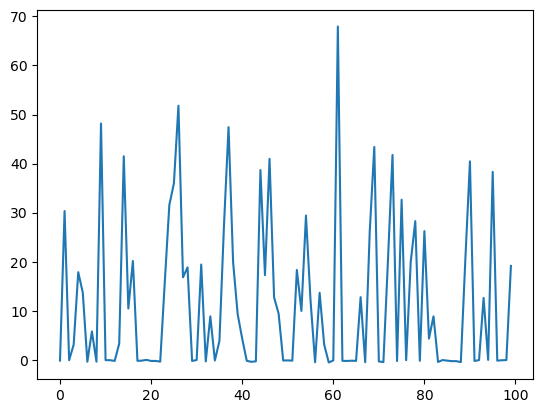

In [63]:
fig, axs = plt.subplots()

ax = axs
ax.plot(data_reduced.cpu().detach().numpy())

# 3. Block to Peform reduction on LIBS and HSI

This block reduces the two modalities to the same size and combines them into a combined feature space. 

The combined feature space could by achieve by:

- Multiplication
- Addition
- Convolution
- ???

In [124]:
class ModDim(nn.Module):
    def __init__(self, in_libs, in_hsi, out_features, number_layers):
        super(ModDim, self).__init__()

        self.LIBS_layer = ReduceDim(in_libs, out_features, number_layers)
        self.HSI_layer = ReduceDim(in_hsi, out_features, number_layers)

    def forward(self, x_l, x_h):
        x = (self.LIBS_layer(x_l) + self.HSI_layer(x_h))/2
        x = F.tanh(x)
        return x

In [125]:
comb_reduce = ModDim(in_libs = libs.shape[-1], 
                    in_hsi = hsi.shape[-1],
                    out_features = 100,
                    number_layers = 3)

data_l = torch.Tensor(libs[40, 40]).to(device)
data_h = torch.Tensor(hsi[40, 40]).to(device)

dim_reduce = comb_reduce.cuda()
print(f'FEATURE REDUCTION MODEL: \n {comb_reduce}')

FEATURE REDUCTION MODEL: 
 ModDim(
  (LIBS_layer): ReduceDim(
    (block): Sequential(
      (0): Linear(in_features=14336, out_features=9591, bias=False)
      (1): Linear(in_features=9591, out_features=4846, bias=False)
      (2): Linear(in_features=4846, out_features=100, bias=False)
    )
  )
  (HSI_layer): ReduceDim(
    (block): Sequential(
      (0): Linear(in_features=284, out_features=223, bias=False)
      (1): Linear(in_features=223, out_features=162, bias=False)
      (2): Linear(in_features=162, out_features=100, bias=False)
    )
  )
)


In [126]:
dt_comb = dim_reduce(data_l, data_h)

In [127]:
dt_comb.size()

torch.Size([100])

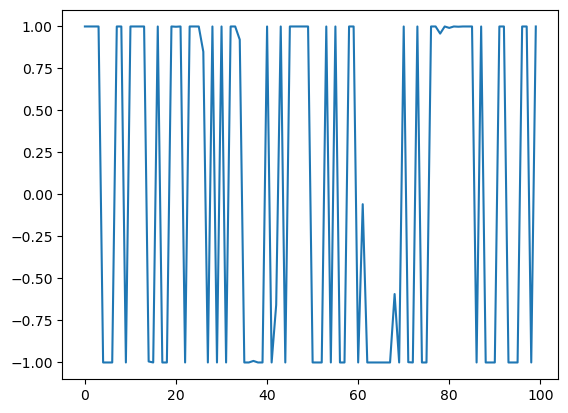

In [128]:
fig, axs = plt.subplots()

ax = axs
ax.plot(dt_comb.cpu().detach().numpy())